# **Renew Power Hiring Hackathon**
https://machinehack.com/hackathons/renew_power_hiring_hackathon/overview

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install catboost

In [31]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import time
from xgboost import XGBRFRegressor
from catboost import CatBoostRegressor, cv
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

## 1. Load and Preprocessing

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Renew_Power/train.csv' )
test = pd.read_csv('/content/drive/MyDrive/Renew_Power/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Renew_Power/submission.csv')

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909604 entries, 0 to 909603
Data columns (total 23 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   timestamp                               909604 non-null  float64
 1   active_power_calculated_by_converter    909604 non-null  float64
 2   active_power_raw                        909604 non-null  float64
 3   ambient_temperature                     909604 non-null  float64
 4   generator_speed                         909604 non-null  float64
 5   generator_winding_temp_max              909604 non-null  float64
 6   grid_power10min_average                 909604 non-null  float64
 7   nc1_inside_temp                         909604 non-null  float64
 8   nacelle_temp                            909604 non-null  float64
 9   reactice_power_calculated_by_converter  909604 non-null  float64
 10  reactive_power                          9096

In [5]:
print(train.columns)
print("")
print(test.columns)

Index(['timestamp', 'active_power_calculated_by_converter', 'active_power_raw',
       'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
       'reactice_power_calculated_by_converter', 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
       'turbine_id', 'Target'],
      dtype='object')

Index(['timestamp', 'active_power_calculated_by_converter', 'active_power_raw',
       'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
       'reactice_power_calculated_by_converter', 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
       'turbine_id'],
      dtype='object')


In [6]:
train.head()

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,165.501518,280.864782,7.057000,0.544082,Turbine_108,47.582787
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,113.835236,299.552460,5.474937,0.469031,Turbine_18,46.070328
2,2021-01-25 06:26:00,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,281.452253,84.960106,8.092457,0.622318,Turbine_105,39.989236
3,2021-10-30 03:47:00,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,75.017531,87.261119,4.071032,0.760719,Turbine_15,46.056587
4,2021-03-15 00:39:00,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,160.202421,313.724818,6.357943,0.346068,Turbine_01,54.346095


In [7]:
month_dict = {1: "January",2: "February", 3: "March", 4: "April",
             5: "May", 6: "June", 7: "July", 8: "August",
             9: "September", 10: "October", 11: "November", 12: "December"}

In [8]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [9]:
train.head()

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,165.501518,280.864782,7.057000,0.544082,Turbine_108,47.582787
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,113.835236,299.552460,5.474937,0.469031,Turbine_18,46.070328
2,2021-01-25 06:26:00,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,281.452253,84.960106,8.092457,0.622318,Turbine_105,39.989236
3,2021-10-30 03:47:00,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,75.017531,87.261119,4.071032,0.760719,Turbine_15,46.056587
4,2021-03-15 00:39:00,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,160.202421,313.724818,6.357943,0.346068,Turbine_01,54.346095


In [10]:
## Feature Engineering (Date & Time)
train["Year"] = train['timestamp'].dt.year
train["Month"] = train['timestamp'].dt.month
train["Day"] = train['timestamp'].dt.day
train["Hours"] = train['timestamp'].dt.hour
train["Minutes"] = train['timestamp'].dt.minute
train["Seconds"] = train['timestamp'].dt.second
train["Month_str"] = train["Month"].replace(month_dict)
train.head()

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,...,wind_speed_turbulence,turbine_id,Target,Year,Month,Day,Hours,Minutes,Seconds,Month_str
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,...,0.544082,Turbine_108,47.582787,2021,2,19,20,18,0,February
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,...,0.469031,Turbine_18,46.070328,2021,4,27,4,55,0,April
2,2021-01-25 06:26:00,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,...,0.622318,Turbine_105,39.989236,2021,1,25,6,26,0,January
3,2021-10-30 03:47:00,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,...,0.760719,Turbine_15,46.056587,2021,10,30,3,47,0,October
4,2021-03-15 00:39:00,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,...,0.346068,Turbine_01,54.346095,2021,3,15,0,39,0,March


In [11]:
## Feature Engineering (Date & Time)
test["Year"] = test['timestamp'].dt.year
test["Month"] = test['timestamp'].dt.month
test["Day"] = test['timestamp'].dt.day
test["Hours"] = test['timestamp'].dt.hour
test["Minutes"] = test['timestamp'].dt.minute
test["Seconds"] = test['timestamp'].dt.second
test["Month_str"] = test["Month"].replace(month_dict)
test.head()

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,...,wind_speed_raw,wind_speed_turbulence,turbine_id,Year,Month,Day,Hours,Minutes,Seconds,Month_str
0,2021-05-06 15:02:00,15.507537,19.956882,40.233264,410.538834,57.357366,84.008399,48.826597,45.363477,2.419202,...,2.438629,0.790435,Turbine_14,2021,5,6,15,2,0,May
1,2021-12-04 06:11:00,472.577255,478.373881,12.306687,965.077563,51.796727,492.531362,27.457511,24.045565,96.152070,...,5.900371,0.544198,Turbine_19,2021,12,4,6,11,0,December
2,2021-08-31 19:03:00,447.829615,451.158264,29.106771,948.035899,60.493098,393.151576,39.410553,35.715697,90.251529,...,5.924923,0.513481,Turbine_14,2021,8,31,19,3,0,August
3,2021-09-19 19:01:00,254.014336,249.438965,27.074900,804.963776,55.741899,178.715101,29.476841,31.151895,89.273838,...,4.409707,0.448881,Turbine_120,2021,9,19,19,1,0,September
4,2021-04-04 02:21:00,1174.930566,1202.654077,32.148434,1199.754858,67.272313,1115.850317,31.920549,30.864277,189.731989,...,7.822326,0.561465,Turbine_158,2021,4,4,2,21,0,April


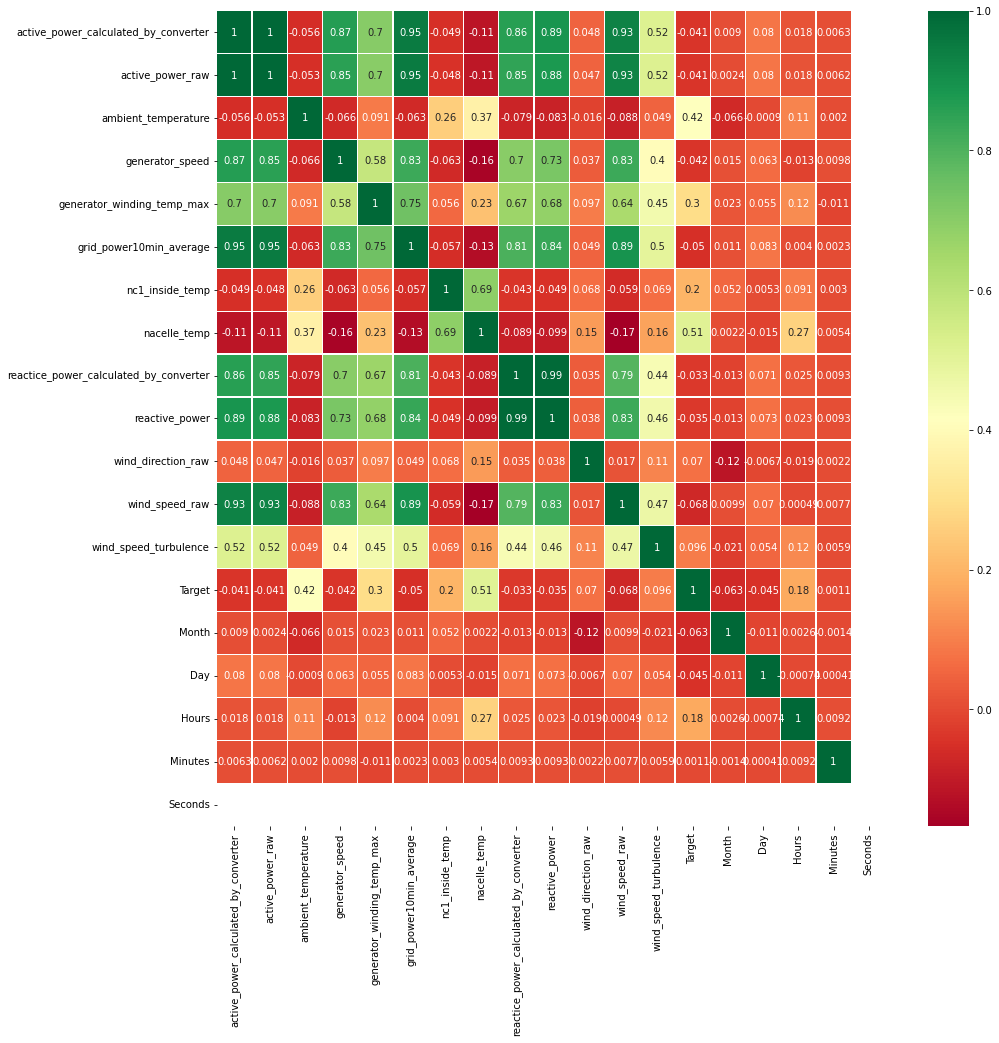

In [12]:
plt.figure(figsize=(15,15))
sns.heatmap(train.drop(["Year"],axis=1).corr(), linewidths=.25,cmap="RdYlGn", annot=True)
plt.show()

In [21]:
train_data = train[['active_power_calculated_by_converter', 'active_power_raw',
       'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
       'reactice_power_calculated_by_converter', 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
       'Hours', 'Target'
               ]]

test_data = test[['active_power_calculated_by_converter', 'active_power_raw',
       'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
       'reactice_power_calculated_by_converter', 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
       'Hours'
               ]]

## CatBoost model


In [22]:
X = train_data.drop(["Target"], axis=1)
y = train_data["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

In [23]:
cb_model = CatBoostRegressor(loss_function='MAPE')

In [24]:
cb_model.fit(X_train, y_train)

0:	learn: 0.0406690	total: 198ms	remaining: 3m 17s
1:	learn: 0.0403777	total: 357ms	remaining: 2m 58s
2:	learn: 0.0400889	total: 500ms	remaining: 2m 46s
3:	learn: 0.0398116	total: 637ms	remaining: 2m 38s
4:	learn: 0.0395434	total: 773ms	remaining: 2m 33s
5:	learn: 0.0392802	total: 912ms	remaining: 2m 31s
6:	learn: 0.0390082	total: 1.05s	remaining: 2m 28s
7:	learn: 0.0387615	total: 1.2s	remaining: 2m 28s
8:	learn: 0.0384962	total: 1.33s	remaining: 2m 26s
9:	learn: 0.0382577	total: 1.47s	remaining: 2m 25s
10:	learn: 0.0380134	total: 1.62s	remaining: 2m 25s
11:	learn: 0.0377742	total: 1.75s	remaining: 2m 24s
12:	learn: 0.0375410	total: 1.89s	remaining: 2m 23s
13:	learn: 0.0373066	total: 2.03s	remaining: 2m 22s
14:	learn: 0.0370932	total: 2.17s	remaining: 2m 22s
15:	learn: 0.0368759	total: 2.3s	remaining: 2m 21s
16:	learn: 0.0366647	total: 2.44s	remaining: 2m 21s
17:	learn: 0.0364519	total: 2.59s	remaining: 2m 21s
18:	learn: 0.0362457	total: 2.73s	remaining: 2m 21s
19:	learn: 0.0360545	tot

In [25]:
y_pred = cb_model.predict(X_test)

In [26]:
print(mean_absolute_percentage_error(y_test, y_pred))

0.022080948433204343


### **Cross-Validation**

In [32]:
grid = {'learning_rate': [0.3, 0.5, 0.4, 0.1],
        'max_depth': [4, 5, 6, 7, 8, 9, 10],
        'l2_leaf_reg': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

model = CatBoostRegressor(iterations=120, loss_function='MAPE')

randomized_search_result = model.randomized_search(grid,
            X,
            y,
            cv=5,
            partition_random_seed=42,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=None,
            train_size=0.8,
            verbose=0,
            plot=False)

0:	learn: 0.5007665	test: 0.5008154	best: 0.5008154 (0)	total: 246ms	remaining: 29.2s
1:	learn: 0.2516888	test: 0.2517427	best: 0.2517427 (1)	total: 431ms	remaining: 25.4s
2:	learn: 0.1298247	test: 0.1298912	best: 0.1298912 (2)	total: 644ms	remaining: 25.1s
3:	learn: 0.0772536	test: 0.0772903	best: 0.0772903 (3)	total: 838ms	remaining: 24.3s
4:	learn: 0.0551483	test: 0.0551608	best: 0.0551608 (4)	total: 1.04s	remaining: 23.9s
5:	learn: 0.0439276	test: 0.0439466	best: 0.0439466 (5)	total: 1.26s	remaining: 24s
6:	learn: 0.0378086	test: 0.0378196	best: 0.0378196 (6)	total: 1.43s	remaining: 23.1s
7:	learn: 0.0340282	test: 0.0340355	best: 0.0340355 (7)	total: 1.61s	remaining: 22.6s
8:	learn: 0.0319889	test: 0.0320092	best: 0.0320092 (8)	total: 1.88s	remaining: 23.1s
9:	learn: 0.0307384	test: 0.0307632	best: 0.0307632 (9)	total: 2.15s	remaining: 23.7s
10:	learn: 0.0298583	test: 0.0298923	best: 0.0298923 (10)	total: 2.39s	remaining: 23.7s
11:	learn: 0.0291745	test: 0.0292255	best: 0.0292255 (

In [39]:
print(model.get_feature_importance(prettified=True))

                                Feature Id  Importances
0                             nacelle_temp    19.967220
1                      ambient_temperature    16.089610
2                          nc1_inside_temp    14.276608
3               generator_winding_temp_max    13.916777
4                                    Hours     9.880301
5                       wind_direction_raw     7.677579
6                  grid_power10min_average     7.119200
7                           reactive_power     3.786080
8   reactice_power_calculated_by_converter     2.189277
9     active_power_calculated_by_converter     2.025667
10                        active_power_raw     1.936218
11                   wind_speed_turbulence     0.620376
12                         generator_speed     0.285961
13                          wind_speed_raw     0.229126


In [41]:
print(model.get_best_score())

{'learn': {'MAPE': 0.01916472174769238}}


In [45]:
preds = model.predict(X_test)

In [46]:
print("MAPE: {}".format(mean_absolute_percentage_error(y_test, preds)))

MAPE: 0.01916680781917196


In [48]:
sample_submission.shape

(303202, 1)

In [50]:
target_data = model.predict(test_data)
len(target_data)

303202

In [51]:
submission_cb = pd.DataFrame(target_data, columns=["Target"])

In [52]:
submission_cb.head()

,Target
0,49.684144
1,41.861873
2,48.978797
3,46.560514
4,45.697235


In [54]:
submission_cb.to_csv("/content/drive/MyDrive/Renew_Power/submission_output.csv", index=False)

In [74]:
train["timestamp"] = train["timestamp"].values.astype(float)
test["timestamp"] = test["timestamp"].values.astype(float)

In [75]:
train_int_cols= ['timestamp', 'active_power_calculated_by_converter', 'active_power_raw',
       'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
       'reactice_power_calculated_by_converter', 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
       'Target']
train_cat_cols = ['turbine_id']

In [76]:
test_int_cols= ['timestamp', 'active_power_calculated_by_converter', 'active_power_raw',
       'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
       'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
       'reactice_power_calculated_by_converter', 'reactive_power',
       'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence']
test_cat_cols = ['turbine_id']

In [77]:
train_numerical_series = train[train_int_cols]
train_categorical_series = train[train_cat_cols ]

In [78]:
test_numerical_series = test[test_int_cols]
test_categorical_series = test[test_cat_cols ]

In [79]:
train_new = pd.concat([train_numerical_series, pd.get_dummies(train_categorical_series)], axis=1)
test_new = pd.concat([test_numerical_series, pd.get_dummies(test_categorical_series)], axis=1)

In [80]:
train_new.head()

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,...,turbine_id_Turbine_123,turbine_id_Turbine_13,turbine_id_Turbine_139,turbine_id_Turbine_14,turbine_id_Turbine_15,turbine_id_Turbine_158,turbine_id_Turbine_18,turbine_id_Turbine_19,turbine_id_Turbine_20,turbine_id_Turbine_97
0,1.613766e+18,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,...,0,0,0,0,0,0,0,0,0,0
1,1.619499e+18,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,...,0,0,0,0,0,0,1,0,0,0
2,1.611556e+18,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,...,0,0,0,0,0,0,0,0,0,0
3,1.635566e+18,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,...,0,0,0,0,1,0,0,0,0,0
4,1.615769e+18,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,...,0,0,0,0,0,0,0,0,0,0


In [81]:
X_new = train_new.drop(["Target"], axis=1)
y_new = train_new['Target']

In [82]:
train_X, test_X, y_train, y_test = train_test_split(X_new, y_new, test_size=0.1, random_state=1)

In [84]:
model.fit(train_X, y_train)

0:	learn: 0.0331553	total: 505ms	remaining: 1m
1:	learn: 0.0284557	total: 1.04s	remaining: 1m 1s
2:	learn: 0.0255145	total: 1.58s	remaining: 1m 1s
3:	learn: 0.0236811	total: 2.58s	remaining: 1m 14s
4:	learn: 0.0218627	total: 3.13s	remaining: 1m 12s
5:	learn: 0.0210082	total: 3.72s	remaining: 1m 10s
6:	learn: 0.0200304	total: 4.26s	remaining: 1m 8s
7:	learn: 0.0195238	total: 4.78s	remaining: 1m 6s
8:	learn: 0.0191073	total: 5.29s	remaining: 1m 5s
9:	learn: 0.0188775	total: 5.79s	remaining: 1m 3s
10:	learn: 0.0183903	total: 6.3s	remaining: 1m 2s
11:	learn: 0.0181857	total: 6.8s	remaining: 1m 1s
12:	learn: 0.0178093	total: 7.5s	remaining: 1m 1s
13:	learn: 0.0176534	total: 8.36s	remaining: 1m 3s
14:	learn: 0.0174786	total: 9.07s	remaining: 1m 3s
15:	learn: 0.0173116	total: 9.66s	remaining: 1m 2s
16:	learn: 0.0171202	total: 10.3s	remaining: 1m 2s
17:	learn: 0.0169980	total: 10.8s	remaining: 1m 1s
18:	learn: 0.0169058	total: 11.3s	remaining: 59.9s
19:	learn: 0.0167589	total: 11.8s	remaining:

In [85]:
preds_y = model.predict(test_X)

In [88]:
print('MAPE (Validation): ', mean_absolute_percentage_error(y_test, preds_y))

MAPE (Validation):  0.013038213520231023


In [92]:
preds_train = model.predict(train_X)
print('MAPE (Training): ', mean_absolute_percentage_error(y_train, preds_train))

MAPE (Training):  0.012769382805822497


In [93]:
new_preds = model.predict(test_new)

In [94]:
len(new_preds)

303202

In [95]:
new_submission = pd.DataFrame(new_preds, columns=["Target"])
new_submission

,Target
0,49.944576
1,41.366785
2,49.020065
3,45.300348
4,45.219718
...,...
303197,50.069242
303198,46.790662
303199,46.892394
303200,47.065603


In [96]:
new_submission.to_csv("/content/drive/MyDrive/Renew_Power/submission_new.csv", index=False)